# 19.07 Overfitting and Regularization

In this notebook, the focus will be on the problem of **overfitting** and **regularization**, which is a key approach to solving overfitting.  After that, an exploration of **Lasso**, **Ridge**, and **ElasticNet** regressions, which are three variants of linear regression that incorporate regularization in their loss functions, will commence.

#### Overfitting 
One of the main challenges in machine learning is to design models that perform well not just on a training set but also on a test set or mor generally on unseen observations.  More concretely, you want: 
- your models to have a low error rate on the training set.
- the difference between the errors in the test set and in the training set to be low as well.

A model's ability to achieve the second requirement is called **generalization**, and the difference between the errors in the test and training sets is called the **generalization gap**.  A good model should generalize well, and its generalization gap should be as small as possible.  Overfitting and underfitting are foundational concepts in machine learning and understanding them is crucial for designing good models.  If the generalization gap of a model is larger than you want it is called **overfitting**.  If the training performance of a model is low, this is called **underfitting**.

In an earlier notebook that discussed goodness of fit, the goal was to come up with models that didn't underfit.  However, avoiding underfitting is only one side of the selection of a good model.  The second part is related to prediction, and this is where the discussion of overfitting comes in.  

To understand overfitting better, you'll work through an example.  Below, you'll generate a quadratic relationship between two variables.  Then you'll estimate the relationship with three different linear regression models: one using a linear, one using a quadratic, and one with a $10^{th}$ order polynomial of the feature.



In [1]:
import warnings

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression

warnings.filterwarnings(action="ignore")

In [3]:
np.random.seed(456)

# X is the feature 
X = pd.DataFrame(25-np.arange(1,51))

# Define Y as a quadratic function of X
# Additionally, add a little nose to Y
Y = X + X**2 + pd.DataFrame(np.random.normal(0,100,50)) 

# This is the model with linear feature
lrm_underfit = LinearRegression().fit(X,Y)
preds_underfit = lrm_underfit.predict(X)

# This is the model with quadratic feature 
X_correct = pd.concat([X, X**2], axis=1)
lrm_correct = LinearRegression().fit(X_correct, Y)
preds_correct = lrm_correct.predict(X_correct)

# This is the model with up to 10th order polynomial of the feature
X_overfit = pd.concat([X**i for i in range(1,11)], axis=1)
lrm_overfit = LinearRegression().fit(X_overfit, Y)
preds_overfit = lrm_overfit.predict(X_overfit)

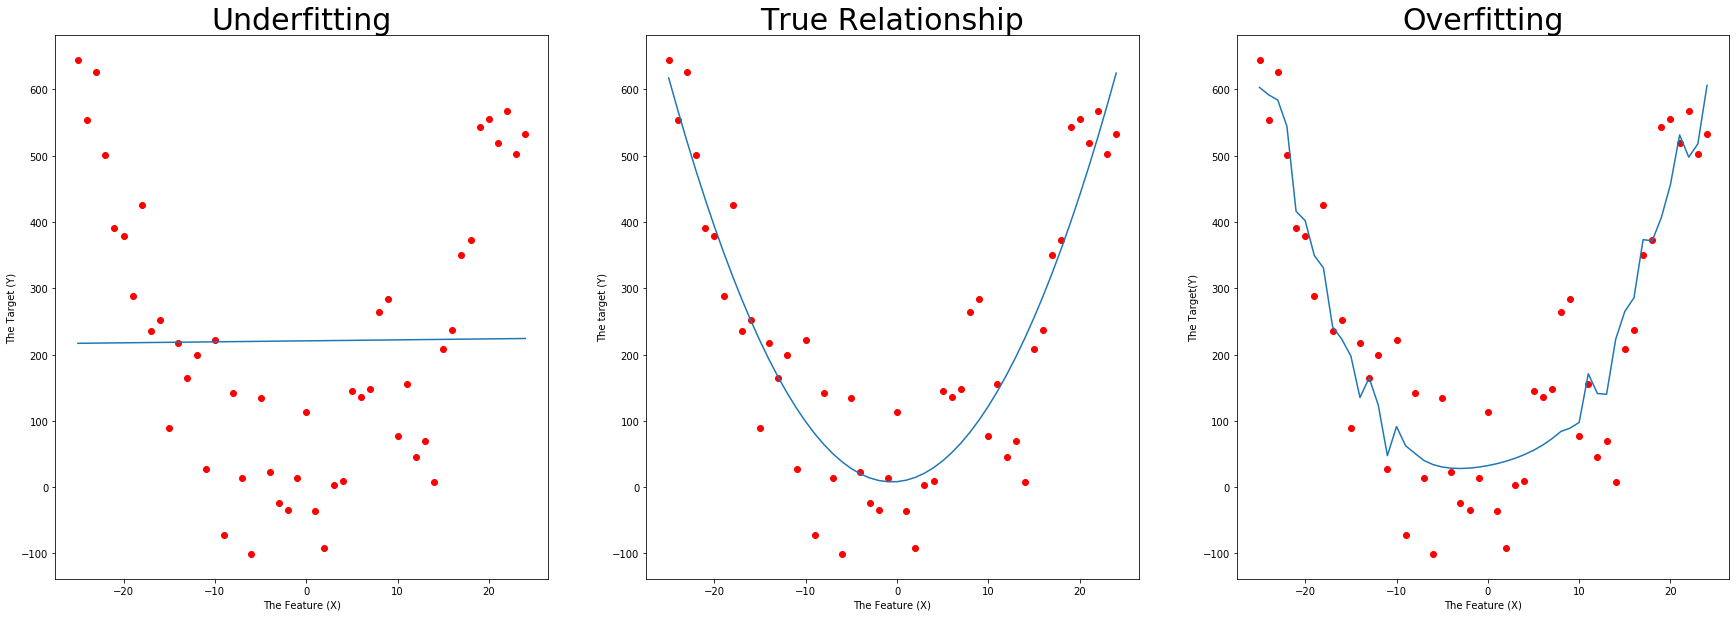

In [5]:
# Plot the predictions of the three models
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.scatter(X,Y, color="red")
plt.plot(X, preds_underfit)
plt.title("Underfitting", fontsize=30)
plt.xlabel("The Feature (X)", fontsize=10)
plt.ylabel("The Target (Y)", fontsize=10)

plt.subplot(1,3,2)
plt.scatter(X, Y, color="red") 
plt.plot(X, preds_correct)
plt.title("True Relationship", fontsize=30)
plt.xlabel("The Feature (X)", fontsize=10)
plt.ylabel("The target (Y)", fontsize=10)

plt.subplot(1,3,3)
plt.scatter(X,Y, color="red")
plt.plot(X, preds_overfit)
plt.title("Overfitting", fontsize=30)
plt.xlabel("The Feature (X)", fontsize=10)
plt.ylabel("The Target(Y)", fontsize=10)

plt.show()

The first chart demonstrates underfitting.  Since the true relationship is quadratic, by fitting a straight line, the model does a poor job explaining variation in the target.  

The third chart illustrates overfitting.  the $10^{th}$ order polynomial fits the noise in the data.  If you look at the rightmost part of the fitted <font color="blue">blue line</font> in the third graph, you see that the line starts to turn down.  However, all of the target values for large values of the feature will continue to come towards the upper-right of the graph.  Hence, the model in the third chard will not correctly predict those values.

The second chart depicts the true relationship between the data.  The fitted line is robust to noise and captures the correct relationship.  **As a general rule, if your model is too complex, it will tend to overfit.  Inversely, if your model is not complex enough, it will underfit the training set.

Keep in mind that a model's complexity is also referred to as its **capacity**.  So if you find that your model is overfitting, you should reduce the complexity or capacity of the model.  You can do this by eliminating some unimportant features from the model or by reducing the degree of the polynomial.  In addition, there are also some general approaches to deal with overfitting.  One of them is **regularization**, covered shortly.

Below, you'll use the house prices dataset and create an overly complex model to overfit the data.  Specifically, you'll use all of the numerical features in the data and their powers up to twenty-one.


In [7]:
import warnings

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error 
from statsmodels.tools.eval_measures import mse, rmse 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 

pd.options.display.float_format = '{:.3f}'.format 
warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "houseprices"
)

In [9]:
# Load the data from the medicalcosts database
engine=create_engine(URL(**kagle), echo=True)

houseprices_df = pd.read_sql("SELECT * FROM houseprices", con=engine)

# No need for an open connection, please close
engine.dispose()

2020-01-09 08:54:35,172 INFO sqlalchemy.engine.base.Engine select version()
2020-01-09 08:54:35,173 INFO sqlalchemy.engine.base.Engine {}
2020-01-09 08:54:35,268 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-09 08:54:35,272 INFO sqlalchemy.engine.base.Engine {}
2020-01-09 08:54:35,371 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-09 08:54:35,374 INFO sqlalchemy.engine.base.Engine {}
2020-01-09 08:54:35,426 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-09 08:54:35,429 INFO sqlalchemy.engine.base.Engine {}
2020-01-09 08:54:35,478 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-09 08:54:35,480 INFO sqlalchemy.engine.base.Engine {}
2020-01-09 08:54:35,583 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

In [19]:
# Y is the target variable
Y = houseprices_df["saleprice"]

numerical_cols = [col_name for col_name in 
    houseprices_df.dtypes[houseprices_df.dtypes.values == "int64"].index 
    if col_name not in ["id","saleprice"]]

# X is the feature set
X = houseprices_df[numerical_cols]
X = pd.concat([X**i for i in range(1,21)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state=465)

print(f"The number of observations in the training set is {X_train.shape[0]} rows and {X_train.shape[1]} cols.")
print(f"The number of observations in the test set is {X_test.shape[0]} rows and {X_test.shape[1]} cols.")

# Fis an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Make some predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print(f"R-squared of the model in the training set is: {lrm.score(X_train, y_train):,.4f}")
print("\n", 30*"-", "Test set statistics", 30*"-", "\n")
print(f"R-squared of the model in the test set is: {lrm.score(X_test, y_test):,.4f}")
print(f"Mean absolute error of the prediction is: {mean_absolute_error(y_test, y_preds_test):,.4f}")
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_test):,.4f}")
print(f"Root mean squared error of the prediction is: {rmse(y_test, y_preds_test):,.4f}")
print(f"Mean absolute percentage error of the prediction is: {np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100:,.4f}")

The number of observations in the training set is 1168 rows and 660 cols.
The number of observations in the test set is 292 rows and 660 cols.
R-squared of the model in the training set is: 0.9520

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: -2,366,570,995,845,498,404,864.0000
Mean absolute error of the prediction is: 413,261,382,670,431.8125
Mean squared error of the prediction is: 15,888,457,348,224,764,857,259,325,915,136.0000
Root mean squared error of the prediction is: 3,986,032,783,134,725.5000
Mean absolute percentage error of the prediction is: 157,673,009,058.7568


As you can see, the R-squared of the model in the training set is 0.95, whereas it's negative in the test set.  Since the difference between them is too large, the model overfits the training set.  You also printed out some prediction statistics on the test set to compare with the models you'll see from here to the end of the notebook.

### Regularization 

To make a model more generalizable a test set, you sometimes adjust the model's learning objective or loss functions.  By doing this, you actually impose your preferences over potential solutions and force the model to choose one of your preferred solutions, assuming there isn't a nonpreferred solution that performs significantly better.  In general, the term **regularization** refers to the process of modifying algorithms in order to lower the generalization gap without sacrificing training performance.

When linear regression was introduced, it was noted that model fit is determined by minimizing the sum of the squared differences between the predicted and actual values.  This is _Ordinary Least Squares_.
$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2$$
It just so happens, however, that you can get more accurate _predictions_ by modifying this cost function.  One way to think of this is that the OLS cost function optimizes variance explained _in the training set_. **Ridge**, **Lasso**, and **ElasticNet** regression are three examples of modifying this cost function.  They each optimize variance explained _in the test sets_.  In general, your goal is to make a model that tells you about the world (and not just about your training sample) so Ridge, Lasso, and ElasticNet solutions are useful.

### Ridge Regression

**Ridge Regression** minimizes this cost function: 
$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta_j^2 $$
Comparing this cost function to the OLS cost function above, you can see it consists of the OLS function with a new part to the right: 
$$\lambda\sum_{j=1}^p\beta_j^2 $$

This new part imposes a penalty for large coefficients.  It represents the sum of the square of all model coefficients (numbered $1$ through $p$), multiplied by the regularization parameter $\lambda$ increases, the coefficient size penalty also increases, and the solution that minimizes the cost function will of necessity have smaller coefficient estimates.  Regularization based on the sum of the squared weights is also called "**L2 regularization".

\* **Note on naming the $\lambda$**: If the convention is to call the regularization parameter "_lambda_" ($\lambda$), why does SciKit-Learn call it "_alpha_"?  It's because lambda is a reserved keyword in Python!

The core principal behind ridge regression is that as models complexity increases and features corelate with one another more and more (become _multicollinear_), coefficients arrived at by OLS become increasingly large.  This is a sign that the model is incorporating too much variance from the training set - in other words, overfitting.  Ridge regression is a model variance minimizer and works to keep this from happening.  For a deep dive into the underlying math and origin of the term "Ridge regression" see this detailed [Stack Exchange answer](http://stats.stackexchange.com/questions/151304/why-is-ridge-regression-called-ridge-why-is-it-needed-and-what-happens-when).

Now build a Ridge regression model on the house prices dataset to deal with the overfitting of your previous model.  You'll use the same features as the linear regression model above:


In [20]:
from sklearn.linear_model import Ridge

# Fittig a ridge regression model.  Alpha is the regularization parameter, usually called lambda.
# As alpha gets larger, parameter shrinkage grows  more pronounced
ridgeregr = Ridge(alpha=10**37)
ridgeregr.fit(X_train, y_train)

# Making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print(f"R-squared of the model in the training set is: {ridgeregr.score(X_train, y_train):,.4f}")
print("\n", 30*"-", "Test set statistics", 30*"-", "\n")
print(f"R-squared of the model in the test set is: {ridgeregr.score(X_test, y_test):,.4f}")
print(f"Mean absolute error of the prediction is: {mean_absolute_error(y_test, y_preds_test):,.4f}")
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_test):,.4f}")
print(f"Root mean squared error of the prediction is: {rmse(y_test, y_preds_test):,.4f}")
print(f"Mean absolute percentage error of the prediction is: {np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100:,.4f}")

R-squared of the model in the training set is: 0.6772

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: 0.2936
Mean absolute error of the prediction is: 48,573.0372
Mean squared error of the prediction is: 4,742,842,002.4220
Root mean squared error of the prediction is: 68,868.2946
Mean absolute percentage error of the prediction is: 28.8818


The R-squared of the training set dropped from 0.95 to 0.67.  Although this seems like a deterioration, if you look at the R-squared in the test set you see that it's now 0.30, which marks a significant jump from negative.  Moreover, all fo the performance statistics from the test set improved quite substantially.  This means that by using Ridge regression, you reduced overfitting.

### Tuning Ridge's Regularization Parameter

In the model above, you set the regularization parameter $\lambda = 10^{37}$.  In Ridge regression, the regularization parameter $\lambda$ can take any value greater than $0$.  The best way to choose an optimal regularization parameter is through cross-validation, checking which parameter gives the most consistent results across training and validation sets.  Note that the **validation set** is the set that you keep apart from the training set when you are applying cross-validation.

### Lasso Regression

Lasso regression shrinks parameter estimates, but the estimates never reach exactly $0$.  **LASO** (Least Absolute Shrinkage and Selection Operator), on the other hand, works by trying to force small parameter estimates to be equal to zero, effectively dropping from the model.  This can prevent overfitting, and also works as an **embedded feature selection method**.  Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and need to optimize processor time, or when you want to arrive at a simpler solution that is easier to interpret.  

The cost function to minimize for Lasso is _very similar to the cost function minimized by Ridge 

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j|$$

The difference is that rather than penalizing by the sum of _squared_ coefficients as Ridge does, Lasso penalizes by the sum of the _absolute values_ of the coefficients.  This means the penalty doesn't increase as swiftly with coefficient size.  Regularization based on the sum of the absolute weights is also called "**L1 regularization".

Why would penalizing with the sum of the absolute values of coefficients lead to a solution with zero estimates for some parameters, while penalizing with the sum of the squares of coefficients does not?  It all comes down to derivatives.  A partial derivative represents the sensitivity of one quantity to change in another quaintly.  In the case of both OLS regression and Ridge regression, the derivative used to find the optimal solution is the partial derivative of the cost function relative to the coefficients in $\beta$: 
$$\frac{\partial}{\partial\beta}$$

Unfortunately, that won't work for Lasso.  While you can calculate a derivative for most of the values of $x$ in Lasso, there is no derivative where $x=0$. So, when you're fitting a Lasso regression, you use an algorithm called **Coordinate Descent**.  Details on coordinate descent will not be covered in this notebook but you can find a detailed treatment in this [Wikipedia article](https://en.wikipedia.org/wiki/Coordinate_descent).

Now, fit a lasso regression model on the house prices data using the same features from before.


In [23]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5)
lassoregr.fit(X_train, y_train)

# Making predictions here
y_preds_train = lassoregr.predict(X_train)
p_preds_test = lassoregr.predict(X_test)

print(f"R-squared of the model in the training set is: {lassoregr.score(X_train, y_train):,.4f}")
print("\n", 30*"-", "Test set statistics", 30*"-", "\n")
print(f"R-squared of the model in the test set is: {lassoregr.score(X_test, y_test):,.4f}")
print(f"Mean absolute error of the prediction is: {mean_absolute_error(y_test, y_preds_test):,.4f}")
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_test):,.4f}")
print(f"Root mean squared error of the prediction is: {rmse(y_test, y_preds_test):,.4f}")
print(f"Mean absolute percentage error of the prediction is: {np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100:,.4f}")

R-squared of the model in the training set is: 0.7531

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: 0.5535
Mean absolute error of the prediction is: 48,573.0372
Mean squared error of the prediction is: 4,742,842,002.4220
Root mean squared error of the prediction is: 68,868.2946
Mean absolute percentage error of the prediction is: 28.8818


The R-squared is 0.75 for the train set and 0.55 for the test set.  The R-squared value in the test set is the highest among the models covered in this notebook.  Also, the difference between the R-squared of the train and test set is also the lowest.  The performance statistics on the test set are also the lowest, which means that this Lasso model performs better than both the Ridge regression and linear regression models you built previously.

### Tuning Lasso's Regularization Parameter

The $\lambda$ for lasso can vary between $0$ (no penalty, acts like OLS) and $\infty$.  If $\lambda$ is too large, all parameters will be set to $0$.  As usual, the best way to determine  the $\lambda$ parameter is cross-validation!

### ElasticNet Regression

As emphasized in the previous discussion in this notebook, both Lasso and Ridge regressions have their own merits and drawbacks.  One popular method that combines both Lasso's L1 regularization with Ridge's L2 regularization is called **ElasticNet regression**  the loss function of ElasticNet regression is: 

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda_1\sum_{j=1}^p|\beta_j| +\lambda_2\sum_{j=1}^p\beta_j^2$$

Notice that when $\lambda$ is equal to zero, this loss function turns into the loss function of Ridge regress and when $\lambda_2$ is equal to zero it becomes the loss function of Lasso regression.  Hence both Lasso and Ridge regression are special cases of ElasticNet regression.  Moreover, when both $\lambda$ and $\lambda_2$ is equal to zero, ElasticNet becomes a linear regression model!

Now, try out ElasticNet on the house prices model:


In [25]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5)
elasticregr.fit(X_train, y_train)

# Making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print(f"R-squared of the model in the training set is: {elasticregr.score(X_train, y_train):,.4f}")
print("\n", 30*"-", "Test set statistics", 30*"-", "\n")
print(f"R-squared of the model in the test set is: {elasticregr.score(X_test, y_test):,.4f}")
print(f"Mean absolute error of the prediction is: {mean_absolute_error(y_test, y_preds_test):,.4f}")
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_test):,.4f}")
print(f"Root mean squared error of the prediction is: {rmse(y_test, y_preds_test):,.4f}")
print(f"Mean absolute percentage error of the prediction is: {np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100:,.4f}")

R-squared of the model in the training set is: 0.6919

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: 0.4110
Mean absolute error of the prediction is: 41,599.5869
Mean squared error of the prediction is: 3,954,150,514.5129
Root mean squared error of the prediction is: 62,882.0365
Mean absolute percentage error of the prediction is: 23.6257


According to the results, ElasticNet's train and test set performances are somewhere between Lasso's and Ridge's

### Tuning ElasticNet's Regularization Parameters

You may notice that in the ElasticNet regression there are two hyperparameters to tune: $\lambda_1$ and $\lambda_2$.  But `SciKit-Learn`'s implementation uses different terminology: alpha and l1_ratio.  Don't get condused by this.  In `SciKit-Learn`'s implementation: 

$alpha = \lambda_1 + \lambda_2$ and $l1\_ratio = \frac{\lambda_1}{(\lambda_1 + \lambda_2)}$. In other words, $\lambda_1 = alpha*l1\_ratio$ and $\lambda_2 = alpha*(1 - l1\_ratio)$. So in effect, they are equivalent!

As emphasized before, when tuning hyperparameters for Elasticnet regression, the best way is to apply cross-validation.

### Assignment

In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Reimplement your model from the previous checkpoint.
* Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do **k-fold cross-validation** to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

This is not a graded checkpoint, but you should discuss your solution with your mentor. After you've submitted your work, take a moment to compare your solution to [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/7.solution_overfitting_and_regularization.ipynb).